# Exercise3: Sensors and Sensor Data

*8 points*

In this exercise you will work with the data from a laser scanner.

## 1. LaserScan Data

Under the same folder of this notebook, you can find a folder named "laserscan". This is a record of the data published by the LIDAR sensor. It records message from topics `/scan`, `/scan_raw` and `/tf`. 

Get the information of the data recording:

In [10]:
!ros2 bag info laserscan


Files:             laserscan.db3
Bag size:          8.5 MiB
Storage id:        sqlite3
Duration:          15.164s
Start:             Nov 13 2023 14:11:14.17 (1699884674.17)
End:               Nov 13 2023 14:11:29.182 (1699884689.182)
Messages:          1301
Topic information: Topic: /scan_raw | Type: sensor_msgs/msg/LaserScan | Count: 605 | Serialization Format: cdr
                   Topic: /tf | Type: tf2_msgs/msg/TFMessage | Count: 304 | Serialization Format: cdr
                   Topic: /scan | Type: sensor_msgs/msg/LaserScan | Count: 392 | Serialization Format: cdr



The last commamd only shows the metadata of the data bag file. To fetch the sensor data we need to replay the bag file, run the following command in a Terminal to play the bagfile in a loop.

```bash
ros2 bag play -l laserscan
```

<button data-commandlinker-command="terminal:create-new" data-commandlinker-args='{"cwd": "03_sensors/"}' class="jupyter-button">Open a Terminal</button>

> Hit: You can arrange the tabs by draging them.

In RViz you can see the TF frames, but not the scan. (Set the global frame to `base_footprint` to have the proper offset of the `laser` frame). 

Your task is to visualize the scan.

With the bagfile running, check the laser scanner topic
```
ros2 topic info /scan
```
It publishes a laser scan message of type `sensor_msgs/LaserScan`. Check out one of the publishes messages.
```
ros2 topic echo /scan -n 1
```
Following is an explanation of the fields.

The header indicates that the scan is with respect to the `/laser` frame.
```
header: 
  seq: 9214
  stamp: 
    secs: 1699884676
    nsecs: 649509920
  frame_id: "laser"
```

The angle min and max tell the range in radians.
```
angle_min: -2.356194496154785
angle_max: 2.356194496154785
```

In [8]:
import math
print(f"2.356194496154785 in degrees is {math.degrees(2.356194496154785)}")

2.356194496154785 in degrees is 135.00000034162267


## Start robot simulation and visualization tools

### Open a desktop environment

For diplaying the visualization and the Gazebo simulation window.

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import utils

utils.display_desktop()

In [ ]:
import rclpy

if not rclpy.ok():
    rclpy.init(args=None)

### Launch Simulation

Copy the following command and run it in a terminal.

```bash
ros2 launch iai_office_sim turtlebot3.launch.py gz_gui:=false
```

<button data-commandlinker-command="terminal:create-new" class="jupyter-button">Open a Terminal</button>

You will see the Rviz popup in the virtual desktop.

### Robot control

The following code will display a GUI tool to control the robot.

You can move the robot around to explore the environment.

In [2]:
velocity_publisher = utils.VelocityPublisher()
utils.robot_steering(velocity_publisher)

#### Robot Steering:

Box(children=(FloatSlider(value=0.0, description='Moving', max=0.5, min=-0.5, orientation='vertical', step=0.0…

## Task1: Parse Sensor data


Descriptions: Laser scan

In [3]:
from sensor_msgs.msg import LaserScan

def start_scan(scan_callback):
    laserscan_subscriber = utils.LaserScanSubscriber(callback=scan_callback)
    try:
        rclpy.spin(laserscan_subscriber)
    except KeyboardInterrupt:
        rclpy.logging.get_logger("Quitting `rclpy.spin(laserscan_subscriber)`").info('Laser Data Listening Stopped!')
    
    laserscan_subscriber.subscription.destroy()
    laserscan_subscriber.destroy_node()


scan_data_series = []
# Fetch 10 sensor data message
def fetch_data(msg):
    global scan_data_series
    scan_data_series.append(msg)
    if len(scan_data_series) > 9:
        raise KeyboardInterrupt

start_scan(fetch_data)
scan_data = scan_data_series[-1]

[INFO] [1728293550.882295895] [Quitting `rclpy.spin(laserscan_subscriber)`]: Laser Data Listening Stopped!


### Visualize sensor data

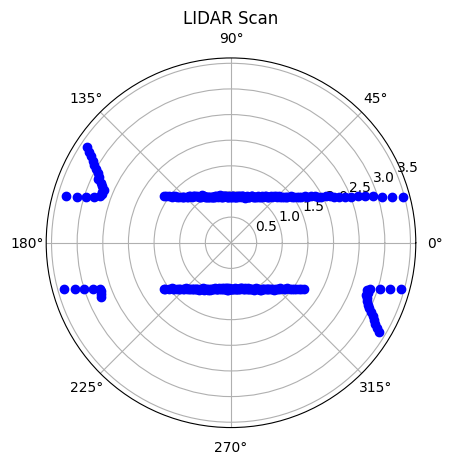

In [4]:
# Example of how to plot the data
import numpy as np
import matplotlib.pyplot as plt

ranges = np.array(scan_data.ranges)
angles = np.arange(scan_data.angle_min, scan_data.angle_max, scan_data.angle_increment)
plt.polar(angles, ranges, 'bo')
plt.title('LIDAR Scan')
plt.show()

In [ ]:
# Your code goes here

## Task2: Draw a map by the laser scan data


Descriptions: SLAM

1. Run the map scanning command.

```bash
ros2 launch slam_toolbox online_async_launch.py use_sim_time:=True
```
<button data-commandlinker-command="terminal:create-new" class="jupyter-button">Open a Terminal</button>

2. Write a simple vacuum robot path algorithm (e.g., "Random Bounce", "Spiral Pattern", "Wall-Following").

> Hint: To restart the simulation, under the terminal press "CTRL" + "c" to stop and run the command again.

In [ ]:
# An example of random walk
import numpy as np

# Detect obstacles in a certain direction
def detect_obstacle(msg, direction=0, min_dis=0.6, angle=60):
    ranges = np.roll(np.array(msg.ranges), np.ceil(direction + angle/2).astype(int))
    distances = ranges[:angle]
    return np.min(distances) < min_dis

def found_open_space(msg):
    get_ranges = lambda arr, dir: np.roll(np.array(arr), np.ceil(dir + 30).astype(int))[:30]
    l_ranges = get_ranges(msg.ranges, 270)
    r_ranges = get_ranges(msg.ranges, 90)
    l_open = np.sum(np.isinf(l_ranges)) > 5 and np.var(l_ranges) > 20
    r_open = np.sum(np.isinf(r_ranges)) > 5 and np.var(r_ranges) > 20
    return r_open or l_open

def random_steering(msg):
    ranges = np.array(msg.ranges)
    ranges[np.isinf(ranges)] = 100
    l_steer_w = np.sum(ranges[-90:])
    r_steer_w = np.sum(ranges[:90])
    sigmoid = 1 / (1 + np.exp(l_steer_w - r_steer_w))
    scale = 1
    angular_z = 2 * scale * sigmoid - scale
    return np.random.rand() - 0.5

# Random walk algorithm
# This is a callback function of the laserscan, will be called every 0.2 seconds.
def radom_walk(msg):
    hit_obstacle = detect_obstacle(msg, min_dis=0.8, angle=40)
    linear_x = velocity_publisher.cmd_vel_msg.linear.x
    angular_z = velocity_publisher.cmd_vel_msg.angular.z
    if hit_obstacle:
        linear_x = 0
    else:
        linear_x = 0.3
    angular_z = random_steering(msg)
    velocity_publisher.publish_velocity(linear_x=linear_x, angular_z=angular_z)
    
print("Press the stop button to interrupt.")
start_scan(radom_walk)
print("Stop the robot.")
velocity_publisher.publish_velocity(linear_x=0, angular_z=0)

Press the stop button to interrupt.


/tmp/ipykernel_389254/4087458481.py:23: RuntimeWarning: overflow encountered in exp
  sigmoid = 1 / (1 + np.exp(l_steer_w - r_steer_w))


In [ ]:
# Your code goes here

### Todos:
- [ ] SLAM
- [ ] Naviation
- [ ] ...